# Preparing fmri data for prediction

This notebook is designed to perform the extra processing steps neccisary to get the already fmri-prep pre-processed fmri time-series ready for machine learning. We will be performing some 'cleaning' on the timeseries, and then the application of different parcellations. 

The raw data used in this notebook was downloaded with datalad on a unix os,
the following command was run from inside the main data ds003097 directory:

`datalad get derivatives/fmriprep/sub-*/func/sub-*_task-moviewatching_space-fsaverage5_hemi-*.func.gii derivatives/fmriprep/sub-*/func/sub-*_task-moviewatching_desc-confounds_regressors.tsv derivatives/physiology/sub-*/physio/sub-*_task-moviewatching_recording-respcardiac_desc-retroicor_regressors.tsv derivatives/fmriprep/sub-*/func/sub-*_task-moviewatching_space-T1w_desc-aseg_dseg.nii.gz derivatives/fmriprep/sub-*/func/sub-*_task-moviewatching_space-T1w_desc-preproc_bold.nii.gz`

Notably, we have avaliable both surface projected data and volumetric representations of the task - in this case movie-watching timeseries. In this notebook we will perform the extraction and cleaning from both versions.

### The Goal:

In this notebook our ultimate goal is to generate and save reduced dimensionality versions of the functional timeseries - along the way we will cover a number of different useful things!

In [1]:
# Who wants to see a bunch of warnings? Not us!
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import os
from os.path import dirname, abspath
import nibabel as nib

# We use the library neurotools a fair amount here
from neurotools.loading import load
from neurotools.transform.parc import merge_parc_hemis
from neurotools.plotting import plot

In [2]:
# Useful directories
main_dr = dirname(abspath(os.getcwd()))
data_dr = os.path.join(main_dr, 'data')
deriv_dr = os.path.join(data_dr, 'ds003097', 'derivatives')
save_dr = os.path.join(deriv_dr, 'proc_fmri', 'moviewatching')

## 1. Load and visualize some surface parcellations of interest

We will start by loading some surface based parcellations that are already in the correct fsaverage5 space. This files have been included along with this directory.

In general, creating a visual of the parcellation is a very useful santity check, especially as we are calling a potentially mysterious function called 'merge_parc_hemis' on two potentially unfamillar files. Sanity checks in data science broadly are extremely important, especially given that as humans coding for whatever reason we tend to make endless little careless mistakes, and little checks like this can be an imporant way to catch some of these mistakes. Also plotting the parcellation gives a great chance to show off my extra special auto-magical plotting function (https://sahahn.github.io/neurotools/plotting.html#plot).

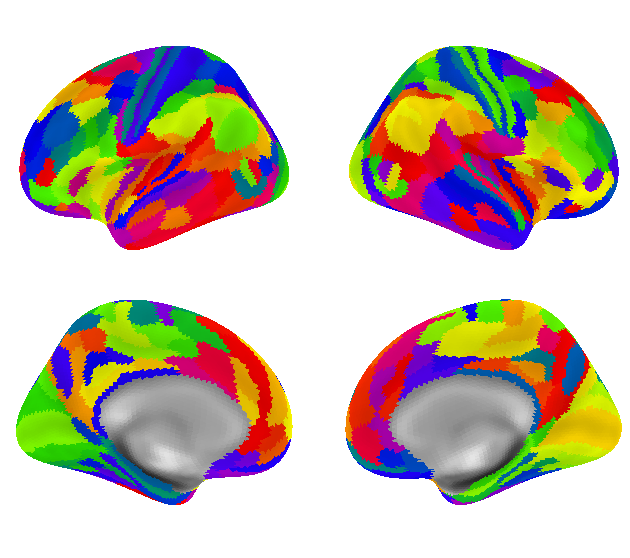

In [3]:
# Load hcp mmp parcellations in fsaverage5 space and merge hemis
hcp_mmp = merge_parc_hemis('lh.hcp-mmp.label.gii',
                           'rh.hcp-mmp.label.gii',
                           background_label=0)

plot(hcp_mmp)

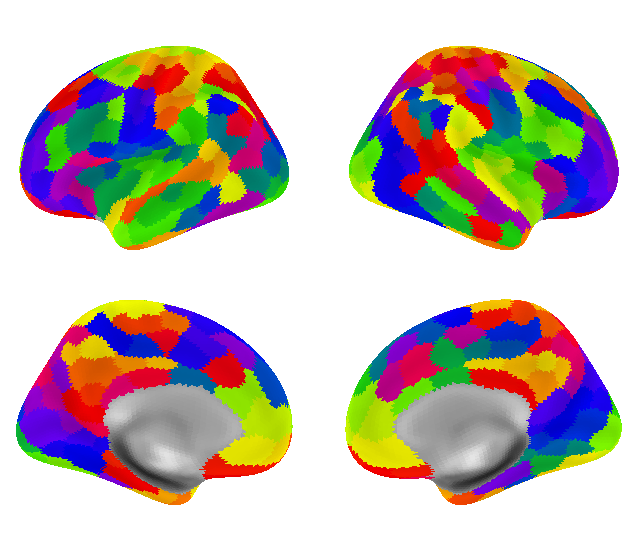

In [4]:
schaefer_400 = merge_parc_hemis('lh.Schaefer2018_400Parcels_17Networks_order.annot',
                                'rh.Schaefer2018_400Parcels_17Networks_order.annot',
                                 background_label=[0, 201])

plot(schaefer_400)

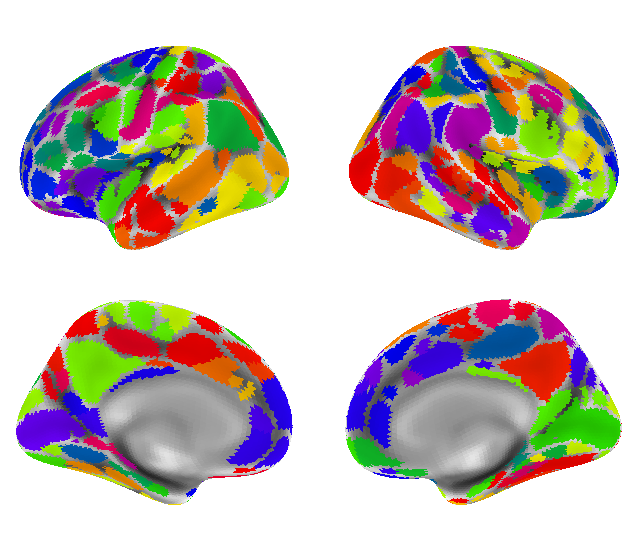

In [5]:
gordon = merge_parc_hemis('lh.gordon.label.gii', 'rh.gordon.label.gii')
plot(gordon)

You may be wondering, is it really neccisary all these different parcellation schemes? The answer, it depends. In this example series one of the questions we are going to ask is how choice of parcellation changes downstream performance, so for us, yes it is important to try a few, but in general it of course will depend on the question  you are trying to answer!

## 2. Apply the parcellations to the data

Okay great, so now that we have some surface parcellations loaded, we can use them in order to extract timeseries values according to each ROI. Before we start, let's look at how the surface projected data is saved.

In [6]:
# Let's look at subject 1's data
subj = '0001'
fmri_func_dr = os.path.join(deriv_dr, 'fmriprep', f'sub-{subj}', 'func')

# One thing to note right away is that the data is split by hemisphere, just like the parcellations
lh_path = os.path.join(fmri_func_dr, f'sub-{subj}_task-moviewatching_space-fsaverage5_hemi-L.func.gii')
rh_path = os.path.join(fmri_func_dr, f'sub-{subj}_task-moviewatching_space-fsaverage5_hemi-R.func.gii')

# Now we can load them, and take a look at the shapes
lh_data = load(lh_path)
rh_data = load(rh_path)
lh_data.shape, rh_data.shape

((10242, 290), (10242, 290))

So what this is telling us is that each hemisphere contains 290 timepoints, what we want to do is go from both seperate hemispheres so ((10242, 290), (10242, 290)) to size number of rois x 290.

Importantly, since we already concatenated the parcellations, we want to concatenate the data itself.

In [7]:
data = np.vstack([lh_data, rh_data])

# Note the lengths now line up
data.shape, gordon.shape

((20484, 290), (20484,))

Now that the shapes line up, we can just use the SurfLabels object to extract the ROI's.

In [8]:
from neurotools.transform import SurfLabels

# Define object
sl = SurfLabels(gordon, vectorize=False)
hemi_rois = sl.fit_transform(data)
hemi_rois.shape

(333, 290)

Great, now we can see that the new shape is 333, the number of gordon ROIs, by 290 the number of timepoints.

## 3. Adding subcortical information

Okay, but the astute reader might notice, what about the subcortical information, don't surface based representations not include any? This is correct, now sometimes it might be fine to just proceed as is, and say, I only care about the cortical connectivity and activation, but in this case let's try to add the anatomically defined subcortical rois to what we've already done, e.g., we will extract 21 subcortical rois, so we want the new shape to be 354 x 290.

So first, let's look at the data as before and load both the 3D aseg parcellation as well as the 3D representation of this subjects data.

In [9]:
parc_loc = os.path.join(fmri_func_dr, f'sub-{subj}_task-moviewatching_space-T1w_desc-aseg_dseg.nii.gz')
data_loc = os.path.join(fmri_func_dr, f'sub-{subj}_task-moviewatching_space-T1w_desc-preproc_bold.nii.gz')

# Note we use nibabel to load here as we want it as a Nifti1Image not numpy array
parc = nib.load(parc_loc)
data = nib.load(data_loc)

parc.shape, data.shape

((44, 61, 48), (44, 61, 48, 290))

We can see that as before the shape's match, except that the data contains the 290 timepoints of interest. Likewise this case is further a little funny because if we look at the unique values of the parcellation, there are more than we are actually interested in.

In [10]:
unique_label_vals = np.unique(parc.get_fdata())
len(unique_label_vals ), unique_label_vals 

(41,
 array([  0.,   2.,   3.,   4.,   5.,   7.,   8.,  10.,  11.,  12.,  13.,
         14.,  15.,  16.,  17.,  18.,  24.,  26.,  28.,  31.,  41.,  42.,
         43.,  44.,  46.,  47.,  49.,  50.,  51.,  52.,  53.,  54.,  58.,
         60.,  63.,  77., 251., 252., 253., 254., 255.]))

These values seems kind of arbitrary so we can also look at the corresponding names by loading in the FreeSurfer info (as provided in this directory, but also avaliable at: https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT)

In [11]:
# This file is formatted awfully so we need to do some
# parsing, basically we just want a corresponding list of
# labels that matches our array of unique_label_vals 
with open('FreeSurferColorLUT.txt', 'r') as f:
    lines = f.readlines()
    
# Make mapping of label to name first
all_labels = {}
for line in lines:
    
    # Get each element of the line in list, w/o white space
    line = [l.strip() for l in line.split(' ') if len(l.strip()) > 0]
    
    try:
        # If casts to int, then valid
        all_labels[int(line[0])] = line[1]
    
    # Skip any that are not label lines
    except:
        continue
        
# Get dict of labels for just unique labels
labels = {i: all_labels[i] for i in unique_label_vals}
len(labels), labels[0], labels[2]

(41, 'Unknown', 'Left-Cerebral-White-Matter')

So that if we proceed as before, but using the NiftiLabelsMasker from nilearn this time (the same class but designed for volumetric data, i.e., I explicitly based the SurfLabelsMasker off this class). We will end up with a time-series by 40 ROIs.

In [12]:
from nilearn.input_data import NiftiLabelsMasker

# Fit masker - passing along the label names too for the report
nlm = NiftiLabelsMasker(parc,
                        labels=labels,
                        background_label=0).fit(data)

# Transform
rois = nlm.transform(data)
rois.shape

(290, 40)

One neat thing about using the function from nilearn function is this report function:

In [13]:
# Note the plotted image is just the middle of the timeseries
nlm.generate_report()

label value,region name,size (in mm^3),relative size (in %)
2.0,Left-Cerebral-White-Matter,239887,19.39
3.0,Left-Cerebral-Cortex,250430,20.25
4.0,Left-Lateral-Ventricle,6267,0.51
5.0,Left-Inf-Lat-Vent,119,0.01
7.0,Left-Cerebellum-White-Matter,15355,1.24
8.0,Left-Cerebellum-Cortex,59073,4.78
10.0,Left-Thalamus,8464,0.68
11.0,Left-Caudate,3861,0.31
12.0,Left-Putamen,5405,0.44
13.0,Left-Pallidum,2227,0.18


Note that since we passed the label names now the entries in the region summary list the names too! This will help us in narrowing down which ROI's we actually want to use. Based on that list we can define the following rois of interest, by their label value.

In [14]:
lh_subcort_rois = [4, 7, 8, 10, 11, 12, 13, 17, 18, 28]
rh_subcort_rois = [43, 46, 47, 49, 50, 51, 52, 53, 54, 60]
brain_stem = [16]

subcort_rois = lh_subcort_rois + rh_subcort_rois + brain_stem

Now we just need to grab the right ones out of the 40 that we already extracted.

In [15]:
# Grab the list of unique label vals actually used to generate the 40

# We just need to ignore 0
ref_labels1 = [l for l in unique_label_vals if l != 0]

# Or, grab directly from the report summary
ref_labels2 = nlm._report_content['summary']['label value']

# Note these are equivilent
ref_labels1 == ref_labels2

True

In [16]:
# Convert from label name to position within the 40 ROIs
inds = [ref_labels1.index(label) for label in subcort_rois]
print(len(inds))

# Then index the extracted ROI's
sub_rois = rois[:, inds]
sub_rois.shape

21


(290, 21)

Then of course the last step would just be to concatenate that to the hemi rois (note the dimensions of the time-points by ROIs are flipped, not a big deal, it is easy to flip back and forth, just something to pay attention to as different function from different libraries may have different expectations in terms of the order).

In [17]:
np.hstack([hemi_rois.T, sub_rois]).shape

(290, 354)

## 4. Writing re-usable functions

Alright, now let's formalize these different steps together into a re-usable generic set of loading functions. First some functions for generating the subcortical rois

In [18]:
def get_subcort_rois(subj):
    
    # Base fmri-prep func dr
    fmri_func_dr = os.path.join(deriv_dr, 'fmriprep', f'sub-{subj}', 'func')

    # Load aseg parcel info
    parc_loc = os.path.join(fmri_func_dr,
                            f'sub-{subj}_task-moviewatching_space-T1w_desc-aseg_dseg.nii.gz')
    parc = nib.load(parc_loc)
    
    # Load bold data - note here that we are using data from the T1w / original
    # subject space.
    data_loc = os.path.join(fmri_func_dr,
                            f'sub-{subj}_task-moviewatching_space-T1w_desc-preproc_bold.nii.gz')
    data = nib.load(data_loc)

    # Extract all 40 ROIs
    nlm = NiftiLabelsMasker(parc, background_label=0)
    rois = nlm.fit_transform(data)
    
    # Return just 21 of interest
    return limit_rois(parc, rois)
    
def limit_rois(parc, rois):
    
    # Get ref labels, might be a bit different for different
    # subjects, so use the actual parc used every time
    unique_label_vals = np.unique(parc.get_fdata())
    ref_labels = [l for l in unique_label_vals if l != 0]
    
    # Define labels of interest
    lh_subcort_rois = [4, 7, 8, 10, 11, 12, 13, 17, 18, 28]
    rh_subcort_rois = [43, 46, 47, 49, 50, 51, 52, 53, 54, 60]
    brain_stem = [16]
    subcort_rois = lh_subcort_rois + rh_subcort_rois + brain_stem
    
    # Convert from label name to real ind
    inds = [ref_labels.index(label) for label in subcort_rois]
    
    # Return just subset
    return rois[:, inds]

In [19]:
get_subcort_rois(subj).shape

(290, 21)

Next, let's put it all together

In [20]:
def load_subj_surf_data(subj, parcel):
    
    # Base fmri-prep func dr
    fmri_func_dr = os.path.join(deriv_dr, 'fmriprep', f'sub-{subj}', 'func')
    
    # Base path for fsaverage data
    base_path = os.path.join(fmri_func_dr,
                             f'sub-{subj}_task-moviewatching_space-fsaverage5_hemi-HEMI.func.gii')
    
    # Load lh and rh data
    lh_data = load(base_path.replace('HEMI', 'L'))
    rh_data = load(base_path.replace('HEMI', 'R'))
    
    # Stack
    hemi_data = np.vstack([lh_data, rh_data])
    
    # Apply rois
    sl = SurfLabels(parcel, vectorize=False)
    hemi_rois = sl.fit_transform(hemi_data)
    
    # Load subcortical rois
    sub_rois = get_subcort_rois(subj)
    
    # Return as time x stacked rois
    return np.hstack([hemi_rois.T, sub_rois])

In [21]:
# And calling the function
data = load_subj_surf_data(subj=subj, parcel=gordon)
data.shape

(290, 354)

## 5. Load Volumetric Parcellations of Interest

Optionally, we could also work with the volumetric registered data directly. In this case we would just want to make sure to have downloaded the standardized space as well.

The basic order of operations is the same, we just want to extract ROIs, the difference here is how we do it. Actually in a lot of ways this will be easier as before, since before we were actually extracting from both surface and volumetric space. The other key piece here to note is that we want to use the task data that has already been registered to the MNI152NLin2009cAsym standard space. This standard space allows us to apply a pre-generated atlas as well as ensures that images from different subjects are aligned with each other.

This additional standard space data can be downloaded through datalad with:

`datalad get derivatives/fmriprep/sub-*/func/sub-*_task-moviewatching_space-MNI152NLin2009cAsym_desc-aseg_dseg.nii.gz derivatives/fmriprep/sub-*/func/sub-*_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz`

/home/sage/anaconda3/envs/bpt/lib/python3.9/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/home/sage/anaconda3/envs/bpt/lib/python3.9/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


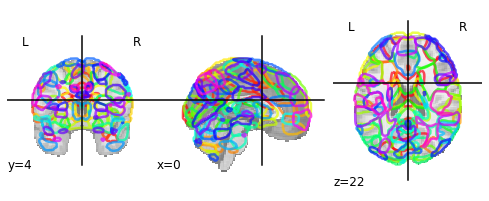

In [22]:
from nilearn.datasets import fetch_atlas_difumo
from nilearn.plotting import plot_prob_atlas
import nibabel as nib

# This parcellaton is interesting in that it is a collection of overlapping maps
difumo_256 = nib.load(fetch_atlas_difumo(dimension=256)['maps'])
plot_prob_atlas(difumo_256)

One thing you will notice about this parcellation right away is that it is a probabilistic parcellation, which means instead of having each voxel be assigned to one label or region, this parcellations contains 256 maps, each of which represent the probability that each voxel belongs to one region / map.

We can also load some non-probabilistic static parcellations:

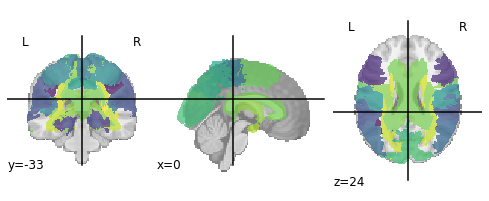

In [23]:
from nilearn.datasets import fetch_atlas_juelich

juelich = fetch_atlas_juelich('maxprob-thr0-1mm')['filename']
plot(juelich)

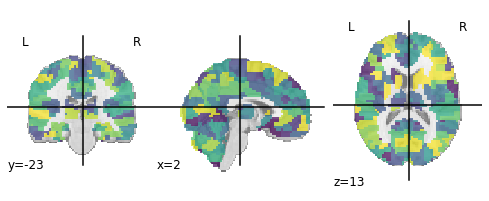

In [24]:
from nilearn.datasets import fetch_atlas_basc_multiscale_2015

basc_444 = nib.load(fetch_atlas_basc_multiscale_2015(version='sym')['scale444'])
plot(basc_444)

## 6. Extracting volumetric ROIs

The practical piece to note here is that for these types of parcellations we just need to use the NiftiMapsMasker from nilearn, but for the standard 1 voxel one label parcellations, we will need to use a different NiftiLabelsMasker object. This condition in the code will just look like:

```
if len(parcel.shape) == 3:
    masker_obj = NiftiLabelsMasker
else:
    masker_obj = NiftiMapsMasker
```

Or together in one function:

In [25]:
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker 

def extract_vol_rois(parcel, data):
    
    # Check if parcellations needs to be loaded
    if isinstance(parcel, str):
        parcel = nib.load(parcel)
    
    # Use correct nilearn object
    if len(parcel.shape) == 3:
        masker_obj = NiftiLabelsMasker
    else:
        masker_obj = NiftiMapsMasker
        
    # Initialize the masking object
    masker = masker_obj(parcel, smoothing_fwhm=None, dtype='float64')
    
    # Return the ROIs
    return masker.fit_transform(data)

## 7. Loading volumetric data / re-usable function

As before, we can formalize this process now by wrapping the loading and extraction in one function.

In [26]:
def load_subj_vol_data(subj, parcel):
    
    # Load the volumetric data from the standard space
    fmri_func_dr = os.path.join(deriv_dr, 'fmriprep', f'sub-{subj}', 'func')
    data_loc = os.path.join(fmri_func_dr,
                            f'sub-{subj}_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
    data = nib.load(data_loc)
    
    # Extract ROIs and return
    return extract_vol_rois(parcel, data)
   

In [27]:
rois = load_subj_vol_data(subj='0001', parcel=basc_444)
rois.shape

(290, 444)

Now as before with the surface version, we have 290 time points by each unique ROI.

## 8. Getting very generic

We can even go one step further and wrap these functions together with a little bit of logic into a function that depending on the parcellation passed will perform the correct extraction! 

In [28]:
def load_subj_data(subj, parcel):
    
    # Allow passing volumetric parcel as str
    if isinstance(parcel, str):
        parcel = nib.load(parcel)
    
    # We won't use any probabilistic surface
    # parcellations, so this logic is a bit easier
    if len(parcel.shape) == 1:
        return load_subj_surf_data(subj, parcel)
    else:
        return load_subj_vol_data(subj, parcel)

In [29]:
# And try it out~
load_subj_data('0001', basc_444).shape, load_subj_data('0001', gordon).shape

((290, 444), (290, 354))

## 9. Loading time-series confounds of interest

As a next step, we will clean the timeseries data with a function from nilearn for a number of different calculated nuisance regressors.

We won't spend a huge amount of time explaining all of the details here, except to say, people have very strong feeling about how which confounds to include. The exact confounds to use are subject to debate, we
make no promise here that the chosen ones are optimal. Instead, they were chosen somewhat arbitrarily as this analyses is mainly for example purposes.

Provided below is just a function directly responsible for loading in some different confounds, head motion, csf signal, motion outlier flag and optionally some cardiac and respitory monitoring info which is pretty neat, but also not avaliable for all subjects, so we will skip in this example (but provide the code for in case folks are interested).

Note lastly, that a lot of this method is dataset specific as it is mostly just loading from files and determined based on how the specific dataset was saved and the information avaliable.

In [30]:
import pandas as pd

def get_confounds_df(subj, include_phys=False):
    
    # Base fmri-prep func dr
    fmri_func_dr = os.path.join(deriv_dr, 'fmriprep', f'sub-{subj}', 'func')
    
    # Load the base confounds df as calculated from fmri prep
    confounds_loc = os.path.join(fmri_func_dr,
                                 f'sub-{subj}_task-moviewatching_desc-confounds_regressors.tsv')
    confounds_df = pd.read_csv(confounds_loc, sep='\t')

    # Estimates of head-motion parameters + their derivative and quadratic term expansions.
    head_motion24 = ['trans_x', 'trans_x_derivative1', 'trans_x_power2',
                     'trans_x_derivative1_power2', 'trans_y', 'trans_y_derivative1',
                     'trans_y_power2', 'trans_y_derivative1_power2', 'trans_z',
                     'trans_z_derivative1', 'trans_z_power2', 'trans_z_derivative1_power2',
                     'rot_x', 'rot_x_derivative1', 'rot_x_power2', 'rot_x_derivative1_power2',
                     'rot_y', 'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
                     'rot_z', 'rot_z_derivative1', 'rot_z_power2', 'rot_z_derivative1_power2']

    # The average signal within anatomically-derived eroded CSF mask.
    csf = ['csf']

    # Regressors of motion spikes for outlier censoring are generated
    # from within fMRIPrep, with defaults = FD > 0.5 mm or DVARS > 1.5.
    motion_outlier = [col for col in list(confounds_df) if 'motion_outlier' in col]
    
    # Put together
    all_confounds_df = confounds_df[head_motion24 + csf + motion_outlier]
    
    if include_phys:
    
        # standard retroicor regressors as calculated from cardiac 
        # and respitory monitoring during scanning.
        phys_loc = os.path.join(deriv_dr, 'physiology',
                                f'sub-{subj}', 'physio',
                                f'sub-{subj}_task-moviewatching_recording-respcardiac_desc-retroicor_regressors.tsv')
        phys_df = pd.read_csv(phys_loc, sep='\t')
    
        # Add phys
        all_confounds_df = all_confounds_df.join(phys_df)
    
    # Fill nans with 0
    all_confounds_df = all_confounds_df.fillna(value=0)
    
    return all_confounds_df

In [31]:
# Get dataframe with confounds
confounds_df = get_confounds_df(subj='0001')
confounds_df

,trans_x,trans_x_derivative1,trans_x_power2,trans_x_derivative1_power2,trans_y,trans_y_derivative1,trans_y_power2,trans_y_derivative1_power2,trans_z,trans_z_derivative1,...,rot_z_derivative1_power2,csf,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07
0,0.000059,0.000000,3.486525e-09,0.000000e+00,0.014532,0.000000,0.000211,0.000000e+00,-0.037397,0.000000,...,0.000000e+00,47038.484375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.000005,-0.000064,2.380318e-11,4.086489e-09,-0.047983,-0.062515,0.002302,3.908150e-03,-0.037341,0.000056,...,2.754737e-07,47053.441406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.006771,-0.006766,4.584969e-05,4.578364e-05,-0.006196,0.041787,0.000038,1.746184e-03,-0.014478,0.022863,...,1.925138e-07,46995.191406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.008391,0.015162,7.041022e-05,2.298959e-04,-0.032009,-0.025813,0.001025,6.663301e-04,-0.040481,-0.026003,...,2.263952e-07,47041.164062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000046,-0.008345,2.150205e-09,6.963418e-05,-0.036840,-0.004831,0.001357,2.334146e-05,-0.020352,0.020128,...,1.839712e-08,47295.609375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,-0.040388,0.003288,1.631199e-03,1.081094e-05,0.060762,0.009179,0.003692,8.425037e-05,-0.026642,-0.011953,...,7.710618e-08,46792.164062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,-0.048095,-0.007707,2.313139e-03,5.939785e-05,0.036243,-0.024520,0.001314,6.012157e-04,-0.002251,0.024391,...,0.000000e+00,46874.757812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287,-0.039738,0.008357,1.579101e-03,6.984279e-05,0.015622,-0.020620,0.000244,4.251926e-04,0.005743,0.007994,...,3.747709e-08,46856.449219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288,-0.048375,-0.008637,2.340121e-03,7.459604e-05,0.041092,0.025469,0.001689,6.486954e-04,-0.015059,-0.020802,...,3.519376e-08,46633.144531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 10. Cleaning the timeseries rois

For this next step, we want to 'clean' the timeseries ROIs we extracted before according to the different confounds. The nilearn clean method for this, which is extremely helpful as it wraps a bunch of different important pieces all in the correct order, allowing us to easily do things like detrend and zscore the de-confounded timeseries. 

In [32]:
from nilearn.signal import clean

def clean_rois(subj, rois, include_phys=False):
    
    confounds_df = get_confounds_df(subj=subj, include_phys=include_phys)
    
    # Run clean on the extracted rois from the earlier example
    cleaned_rois =\
        clean(signals=rois,
              confounds=confounds_df,
              detrend=True,
              standardize='zscore',
              standardize_confounds=True,
              filter='butterworth',
              t_r=2.2)
    
    return cleaned_rois

# And try it out!
cleaned_rois = clean_rois(subj, rois, include_phys=False)
cleaned_rois.shape

(290, 444)

We can visualize the first ROI's time-series before and after.

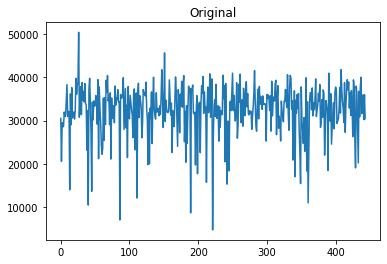

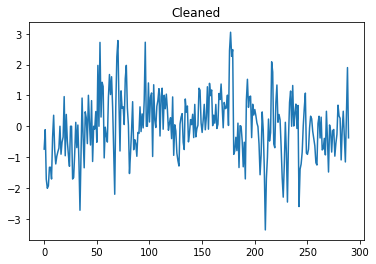

In [33]:
import matplotlib.pyplot as plt

# Vs. the original
plt.title('Original')
plt.plot(rois[0])
plt.show()

# Let's plot an example cleaned timeseries
plt.title('Cleaned')
plt.plot(cleaned_rois[:, 0])
plt.show()

## 11. Writing robust load to process to save functions

Okay, so now that we have all the different pieces, all that is left to do is combine everything together in a set of code that will

1. Load the subjects data + exctract ROIs
2. Clean the time-series
3. Save the final output somewhere for further re-use

Next, we want to consider what the main arguments of this function will look like, namely, one should be the current subject, and one should be the parcellation. Then as some extra pieces we might also want the name of the parcellation for saving purposes as well as the optional choice of running the confounds with or without the physical regressors included. So something like this:

In [34]:
def process_and_save_subject(subj, parcel, parc_name, include_phys=False):
    
    # 1. Load the subjects data + exctract ROIs
    data = load_subj_data(subj=subj, parcel=parcel)
    
    # 2. Clean the time-series
    cleaned_data = clean_rois(subj, data, include_phys=include_phys)

    # 3. Save the final output somewhere for further re-use
    np.save(save_loc, cleaned_data)
    
    return


While that is an okay start, and we have most of the pieces ready, the extra pieces we need to consider for this function are two things:

1. We want the added feature that if a combination of subj / parcellation has already been saved, it should be skipped
2. We want our method to be robust to any subjects who might be missing data, and in this case skip those subjects.

So first, for piece one, let's add in the code for generating the spot to save the subjects processed data
and skipping if already exists to what we already had, then note we will also change the function name to `_process_and_save_subject`.

In [35]:
def _process_and_save_subject(subj, parcel, parc_name, include_phys=False):
    
    # Gen save directory for each subject
    subj_save_dr = os.path.join(save_dr, parc_name, f'sub-{subj}')
    os.makedirs(subj_save_dr, exist_ok=True)

    # Change save name a bit if include_phys
    save_name = 'func_timeseries.npy'
    if include_phys:
        save_name = 'func_timeseries_phys.npy'
    
    # Save cleaned data as numpy array
    save_loc = os.path.join(subj_save_dr, save_name)
    
    # Skip if already exists
    if os.path.exists(save_loc):
        return save_loc
    
    # 1. Load the subjects data + exctract ROIs
    data = load_subj_data(subj=subj, parcel=parcel)
    
    # 2. Clean the time-series
    cleaned_data = clean_rois(subj, data, include_phys=include_phys)

    # 3. Save the final cleaned data
    np.save(save_loc, cleaned_data)
    
    return save_loc

Then for the second piece we just wrap the main function in a loop that just skips any files that prompt an error

In [36]:
def process_and_save_subject(subj, parcel, parc_name, include_phys=False):
    
    # Wrapper with error handling
    try:
        return _process_and_save_subject(subj, parcel, parc_name,
                                         include_phys=include_phys)
    
    # If missing files, skip
    except FileNotFoundError:
        pass

Let's try the method to make sure it works.

In [39]:
# Run, returning save loc
save_loc = process_and_save_subject(subj='0001', parcel=gordon, parc_name='gordon')

# Load
data = np.load(save_loc)
data.shape

(290, 354)

## 12. Run everything

Great, now all that is left to run the method on every combination of subject and parcellation that we want, so
let's start by getting that info together.

In [40]:
# Get a list of all of the fiels in the main dr
subjs_dr = os.path.join(data_dr, 'ds003097')
files = os.listdir(subjs_dr)

# Filter out just names of the subjects
subjs = [s.split('-')[-1] for s in files if 'sub' in s]

# The parcels + names to process
parcels = [hcp_mmp, schaefer_400, gordon,
           difumo_256, juelich, basc_444]
parcel_names = ['hcp_mmp', 'schaefer_400', 'gordon',
                'difumo_256', 'juelich', 'basc_444']

len(subjs), len(parcels)

(928, 6)

Next, we could just write a nested loop and call it on every combination, something like:

```
for subj in subjs:
    for parcel, parc_name in zip(parcels, parcel_names):
        process_and_save_subject(subj, parcel, parc_name)
```

But, we could also easily run this in a multi-core fashion! Granted, this is pretty memory intensive so we can only run a few at once, but using some methods from joblib makes it easy to do the same logic as above, but multi-processed.

In [41]:
from joblib import Parallel, delayed

for parcel, parc_name in zip(parcels, parcel_names):
    Parallel(n_jobs=3)(delayed(process_and_save_subject)(subj,
                                                         parcel=parcel,
                                                         parc_name=parc_name) for subj in subjs)

## 13. Integrate with Brain Predictability Toolbox (BPt)

Now that we have all our data processed and ready for machine learning, we can go one step further and integrate the saved files explicitly into a BPt dataset object. Note: that this requires that the base notebook `prepare_template_dataset.ipynb` have been run - as we are adding the data files to this template dataset.

In [42]:
import BPt as bp

# Load the base template dataframe with targets loaded
data = bp.read_pickle(os.path.join(data_dr, 'datasets', 'template.dataset'))
data.shape

(928, 10)

As a next step, we want to add these saved files in a way that the BPt Dataset (https://sahahn.github.io/BPt/reference/dataset.html) can work with them. To do this, we use Data File's (https://sahahn.github.io/BPt/user_guide/data_files.html).

Basically we will use a method of the dataset called `add_data_files`, which means all we need to do is generate 
a dictionary to pass to it that maps in some way from desired column name to location of where the files are saved. So let's generate this:

In [43]:
# This looks complex but all it does is generate the following dictionary
# that associates each parcellations data with a seperate column, and uses the
# special file globbing wildcard character to specify how to grab subjects data
files = {parcel_name: os.path.join(save_dr, parcel_name, 'sub-*', 'func_timeseries.npy')
         for parcel_name in parcel_names}
files

{'hcp_mmp': '/home/sage/methods_series/data/ds003097/derivatives/proc_fmri/moviewatching/hcp_mmp/sub-*/func_timeseries.npy',
 'schaefer_400': '/home/sage/methods_series/data/ds003097/derivatives/proc_fmri/moviewatching/schaefer_400/sub-*/func_timeseries.npy',
 'gordon': '/home/sage/methods_series/data/ds003097/derivatives/proc_fmri/moviewatching/gordon/sub-*/func_timeseries.npy',
 'difumo_256': '/home/sage/methods_series/data/ds003097/derivatives/proc_fmri/moviewatching/difumo_256/sub-*/func_timeseries.npy',
 'juelich': '/home/sage/methods_series/data/ds003097/derivatives/proc_fmri/moviewatching/juelich/sub-*/func_timeseries.npy',
 'basc_444': '/home/sage/methods_series/data/ds003097/derivatives/proc_fmri/moviewatching/basc_444/sub-*/func_timeseries.npy'}

In [44]:
import glob

# We can see these are just glob path's
len(glob.glob(files['hcp_mmp']))

871

Then, we can just call the add data files method, using the default settings

In [45]:
# The auto function is smart and set by default
# from just from the filenames it can figure out correct index
data = data.add_data_files(files, file_to_subject='auto')

# Drop any subjects with missing data
data = data.drop_subjects_by_nan(scope='data')
data

Setting NaN threshold to: 3.0
Dropped 57 Rows


,basc_444,difumo_256,gordon,hcp_mmp,juelich,schaefer_400
participant_id,,,,,,
sub-0001,Loc(4901),Loc(3139),Loc(2264),Loc(522),Loc(4020),Loc(1393)
sub-0002,Loc(5143),Loc(3381),Loc(2504),Loc(762),Loc(4262),Loc(1633)
sub-0003,Loc(4640),Loc(2878),Loc(2005),Loc(263),Loc(3759),Loc(1134)
sub-0004,Loc(5155),Loc(3393),Loc(2516),Loc(774),Loc(4274),Loc(1645)
sub-0005,Loc(4668),Loc(2906),Loc(2033),Loc(291),Loc(3787),Loc(1162)
...,...,...,...,...,...,...
sub-0923,Loc(4721),Loc(2959),Loc(2086),Loc(344),Loc(3840),Loc(1215)
sub-0924,Loc(5150),Loc(3388),Loc(2511),Loc(769),Loc(4269),Loc(1640)
sub-0925,Loc(4794),Loc(3032),Loc(2158),Loc(416),Loc(3913),Loc(1287)


What do these Loc's mean? In general you shouldn't need to worry about it, just know they can be passed to machine learning pipelines directly, but if interested, they are just a representation of the data file. Basically they correspond to locations in the file mapping, for example:

In [46]:
loc = data.loc['sub-0001', 'gordon']
data_file = data.file_mapping[loc]
data_file 

DataFile(loc='/home/sage/methods_series/data/ds003097/derivatives/proc_fmri/moviewatching/gordon/sub-0001/func_timeseries.npy')

These DataFiles are nice because along with the file_mapping systems, all we need to pass around during ML are just integer index, which are super low memory consumption, then those can be used to look up and load the actual saved data, for example:

In [47]:
data_file.load().shape

(290, 354)

## 14. Save as dataset

The great part about it being a Dataset is now we can just save it as is and load it again in another notebook, ready to go!

In [48]:
data.to_pickle(os.path.join(data_dr, 'datasets', 'fmri.dataset'))